In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU, Flatten
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

In [18]:
data2 = pd.read_csv("../data/PV_panel_power_with_weather_hour.csv", delimiter=";")
data = data2.copy(deep=True)
data = data.drop(["MODELICA", 'MODELICA_ERROR', 'SHADOW'], axis=1)
# df = data.copy(deep=True)
data['DATE'] = pd.to_datetime(data['DATE'])

In [19]:
# Extracting seasonal information
data.set_index('DATE', inplace=True)
data['MONTH'] = data.index.month
data['DAY_OF_YEAR'] = data.index.dayofyear
data['WEEK_OF_YEAR'] = data.index.isocalendar().week
data['DAY_OF_WEEK'] = data.index.dayofweek
data['HOUR'] = data.index.hour

# Selecting relevant columns for modeling
selected_features = ['IRRADIANCE_SOLAR', 'AIR_TEMPERATURE_CELSIUS', 'DIRECTION_WIND', 'IGRO', 'VELOCITY_WIND', 'RAFF_WIND', 'PV_Power',
            'MONTH', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'DAY_OF_WEEK', 'HOUR']

data = data[selected_features].dropna()

# Smoothing all data
data_smooth = data.rolling(window=128, min_periods=1).mean()

fig = px.line(data_smooth['PV_Power'], title='Smoothed Daily PV Power Production')
fig.update_layout(xaxis_title='Date', yaxis_title='PV Power')
fig.show()

In [20]:
# Scaling the data using MaxAbsScaler
scaler = MaxAbsScaler()
scaled_series = scaler.fit_transform(data_smooth)

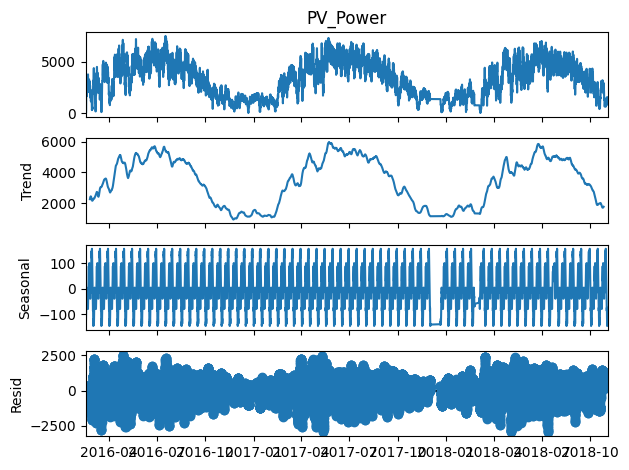

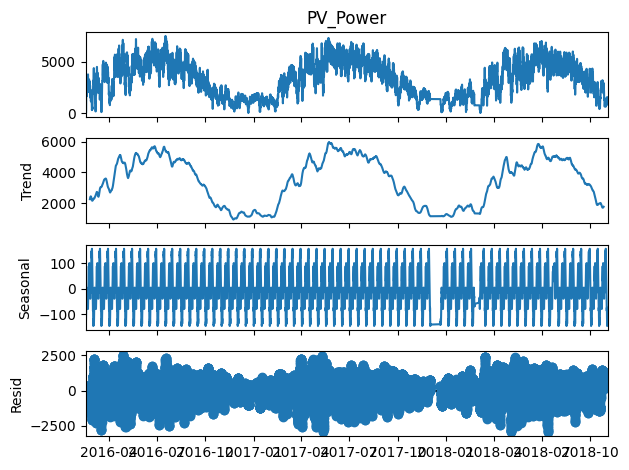

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data_smooth['PV_Power'], model='additive', period=365).plot()

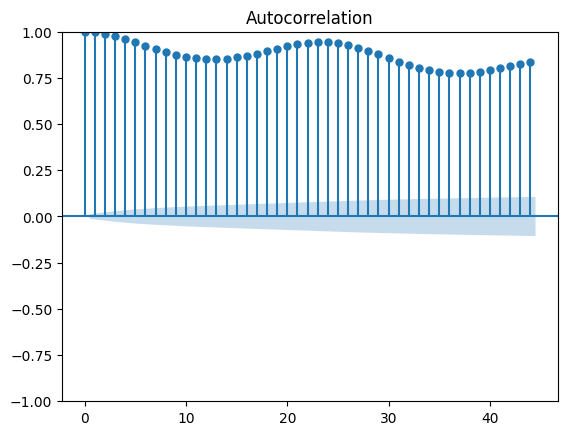

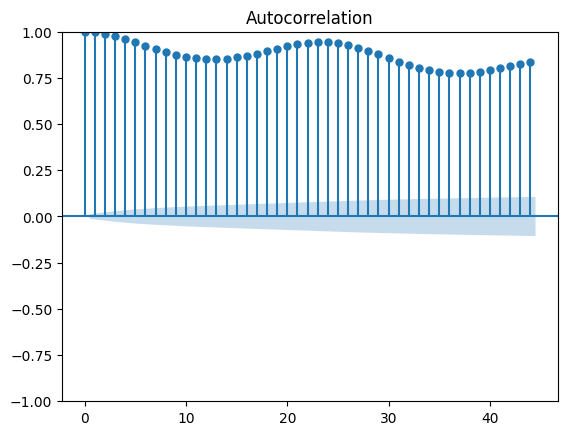

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_smooth['PV_Power'])

In [21]:
def create_dataset(data, time_step=12, pv_power_index= 6):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, pv_power_index])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(scaled_series, time_step, pv_power_index = data.columns.get_loc('PV_Power') )

# Reshaping X for input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# TimeSeries cross-validator (k-fold)
tscv = TimeSeriesSplit(n_splits=5)

# Model definitions to try
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_cnn_1d(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    return model

def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

models = {
    '1D CNN': build_cnn_1d,
    'LSTM': build_lstm,
    'Stacked LSTM': build_stacked_lstm,
    'GRU': build_gru
}

In [22]:
all_y_tests = {}
all_y_preds = {}

# Iterate over different models
for model_name, model_builder in models.items():
    print(f"\nTraining {model_name} model...")
    mse_list, rmse_list, mae_list, r2_list = [], [], [], []
    all_y_test, all_y_pred = [], []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Model definition
        model = model_builder((time_step, X.shape[2]))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Model training
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Predictions
        y_pred = model.predict(X_test)

        # Metrics calculation
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred.flatten())

    # Store true and predicted values for plotting
    all_y_tests[model_name] = all_y_test
    all_y_preds[model_name] = all_y_pred

    # Printing metrics for each fold
    for i in range(len(mse_list)):
        print(f"{model_name} - Fold {i+1} - MSE: {mse_list[i]}, RMSE: {rmse_list[i]}, MAE: {mae_list[i]}, R2: {r2_list[i]}")

    # Calculating and printing mean and standard deviation of metrics
    print(f"\n{model_name} - Average Metrics and Standard Deviations:")
    print(f"MSE: Mean = {np.mean(mse_list)}, Std = {np.std(mse_list)}")
    print(f"RMSE: Mean = {np.mean(rmse_list)}, Std = {np.std(rmse_list)}")
    print(f"MAE: Mean = {np.mean(mae_list)}, Std = {np.std(mae_list)}")
    print(f"R2: Mean = {np.mean(r2_list)}, Std = {np.std(r2_list)}")

# Plotting all models' true vs predicted values on a single graph
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.Series(all_y_tests['Stacked LSTM']).resample('D').mean(), mode='lines', name='True Values (Daily Average)'))
for model_name, y_pred in all_y_preds.items():
    y_pred_daily_avg = pd.Series(y_pred).resample('D').mean()
    fig.add_trace(go.Scatter(y=y_pred_daily_avg, mode='lines', name=f'{model_name} Predicted Values (Daily Average)'))
fig.update_layout(title='True vs Predicted Values for All Models (Daily Average)', xaxis_title='Time', yaxis_title='PV Power')
fig.show()


Training 1D CNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1D CNN - Fold 1 - MSE: 0.0045638154814692, RMSE: 0.06755601735944179, MAE: 0.05421605541860583, R2: 0.8999183091955772
1D CNN - Fold 2 - MSE: 9.03125781148654e-05, RMSE: 0.009503293014259078, MAE: 0.007626932615207528, R2: 0.9984745086551191
1D CNN - Fold 3 - MSE: 3.3710230317363015e-05, RMSE: 0.005806051181083664, MAE: 0.004519165522728967, R2: 0.9991974221256567
1D CNN - Fold 4 - MSE: 7.03700882637925e-05, RMSE: 0.008388688113393685, MAE: 0.005895768170441013, R2: 0.9982182451164417
1D CNN - Fold 5 - MSE: 3.6302271189437726e-05, RMSE: 0.00602513661168257, MAE: 0.0044127874260243526, R2: 0.9989089968512656

1D CNN - Average Metrics and Standard Deviations:
MSE: Mean = 0.0009589021298709317, Std = 0.0018025819160943821
RMSE: Mean = 0.019455837255972157, Std = 0.024090922077414506
MAE: Mean = 0.015334141830601538, Std = 0.019475763759472547
R2: Mean = 0.9789434963888122, Std = 0.03951404637861212

Training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



KeyboardInterrupt: 

In [ ]:
def plot_predictions(dates, actual_values, all_y_preds, window=5):
    """
    Plot comparison of actual and predicted values for each model.

    Args:
        dates (list): List of dates corresponding to the actual and predicted values.
        actual_values (list): List of actual values for the test set.
        all_y_preds (dict): Dictionary of predicted values for each model (model name -> y_pred list).
        window (int): Window size for smoothing the actual and predicted values.

    Returns:
        None
    """
    fig = go.Figure()
    # Smoothing actual values using rolling mean
    actual_smooth = pd.Series(actual_values).rolling(window=window).mean()

    # Adding actual values to the plot
    fig.add_trace(go.Scatter(
        x=dates,
        y=actual_smooth,
        mode='lines',
        name='Actual Values',
        line=dict(dash='dot')
    ))

    for model_name in all_y_preds.keys():
        # Smoothing predicted values using rolling mean
        y_pred_smooth = pd.Series(all_y_preds[model_name]).rolling(window=window).mean()

        # Adding predicted values to the plot
        fig.add_trace(go.Scatter(
            x=dates,
            y=y_pred_smooth,
            mode='lines',
            name=f'{model_name} - Predictions'
        ))

    fig.update_layout(
        title='Comparison of Actual and Predicted Values',
        xaxis_title='Date',
        yaxis_title='Scaled P-Power',
        legend_title='Models',
        template='plotly_white'
    )
    fig.show()

In [ ]:
dates = data2['DATE'][-len(y):]
plot_predictions(dates, all_y_tests['LSTM'], all_y_preds, window=1024)